**Name:** Alex Medina

**Organization:** University of Central Florida

**Project Title:** Lightcurve Analysis of Titan

**Subsection:** Polarization Phase Curves (simple)

**Details:** This section, I just get rid of many steps to get to the final result easier.

In [1]:
#General imports
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Important imports
import vicar
import cv2

Image Paths

In [2]:
pol_images = r'C:\Users\Alex\Desktop\Titan\polarized_images\BL2_P\BL2_POL'

#Have the same path
if_images = r'C:\Users\Alex\Desktop\Titan\polarized_images\BL2_P\BL2_POL'

pol_if_metadata = r'C:\Users\Alex\Desktop\Titan\polarized_images\BL2_P\BL2_POL\pol_data_new.csv'
#Reading the csv file
parameters_df = pd.read_csv(pol_if_metadata)

Effective Radius

In [3]:
#Finding image center

def image_center(image):
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            return (x, y)
    #Debug
    else:
        print("No circle found")
        return None

#To determine the effective radius, as mentioned, I plot the brightness against increasing radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Manual inspection and testing
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs. Radius")
    plt.show()

def effective_radius(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    print("No plateau found")
    return None

Dictionary

In [4]:
#Grouping the circle center and radius for our dictionary
def find_circle_params(image_path):
    vic = vicar.VicarImage(image_path, strict=False)
    image = vic.data_2d
    center = image_center(image)
    radii, fluxes = radii_fluxes_from_image(image, center)
    eff_radius = effective_radius(radii, fluxes)
    return center, eff_radius

#Creating a dictionary with the opus_id being used as the key since it matches the polarized images and IF images
#And the corresponding center coordinates and effective radius are stored as the value

circle_params = {}
for filename in os.listdir(if_images):
    if filename.endswith('_I_over_F.vic'):
        coordinate_image_path = os.path.join(if_images, filename)
        opus_id = filename.split('_')[0]
        try:
            center, eff_radius = find_circle_params(coordinate_image_path)
            circle_params[opus_id] = (center, eff_radius)
            print(f'{filename}: {center}, {eff_radius}')
        #Debug
        except Exception as e:
            print(f"{filename}: {e}")

N1486913_I_over_F.vic: (np.int64(251), np.int64(272)), 186
N1499415_I_over_F.vic: (np.int64(259), np.int64(256)), 266
N1515805_I_over_F.vic: (np.int64(256), np.int64(262)), 206
No circle found
N1521213_I_over_F.vic: cannot unpack non-iterable NoneType object
N1525327_I_over_F.vic: (np.int64(527), np.int64(520)), 511
N1526619_I_over_F.vic: (np.int64(239), np.int64(266)), 271
N1530756_I_over_F.vic: (np.int64(532), np.int64(519)), 541
N1534852_I_over_F.vic: (np.int64(489), np.int64(515)), 541
N1536146_I_over_F.vic: (np.int64(503), np.int64(514)), 536
N1547135_I_over_F.vic: (np.int64(524), np.int64(518)), 541
N1549546_I_over_F.vic: (np.int64(512), np.int64(501)), 536
N1551056_I_over_F.vic: (np.int64(245), np.int64(247)), 261
N1553821_I_over_F.vic: (np.int64(256), np.int64(267)), 266
N1555150_I_over_F.vic: (np.int64(267), np.int64(273)), 246
N1557905_I_over_F.vic: (np.int64(242), np.int64(284)), 231
N1559282_I_over_F.vic: (np.int64(247), np.int64(283)), 201
N1562037_I_over_F.vic: (np.int64(

Stokes Parameters Before Rotation

In [5]:
#Calculating Q and U before rotation
#Using the masked version for consistency but can easily switch to non masked
#Less than a 5% difference in either

def pre_rot_q(pol_image, if_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    R = 2575 #km

    #thet_rad_whole = np.deg2rad(thet_image)
    #weighted_whole = np.sum(if_image * pol_image * np.cos(2*thet_rad_whole))
    #whole = (weighted_whole * pixel_scale**2) / (np.pi * R**2)

    thet_rad_mask = np.deg2rad(thet_masked)
    weighted_mask = np.sum(if_masked * pol_masked * np.cos(2*thet_rad_mask))
    masked = (weighted_mask * pixel_scale**2) / (np.pi * R**2)

    return masked #, whole


def pre_rot_u(pol_image, if_image, thet_image, center, radius, pixel_scale):
    
    mask_pol = np.zeros_like(pol_image)
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if

    mask_thet = np.zeros_like(thet_image)
    cv2.circle(mask_thet, center, radius, 1, thickness=-1)
    thet_masked = thet_image * mask_thet

    R = 2575 #km

    #thet_rad_whole = np.deg2rad(thet_image)
    #weighted_whole = np.sum(if_image * pol_image * np.sin(2*thet_rad_whole))
    #whole = (weighted_whole * pixel_scale**2) / (np.pi * R**2)

    thet_rad_mask = np.deg2rad(thet_masked)
    weighted_mask = np.sum(if_masked * pol_masked * np.sin(2*thet_rad_mask))
    masked = (weighted_mask * pixel_scale**2) / (np.pi * R**2)

    return masked #, whole

In [6]:
#We use the exact same files and images so nothing from the loop has to change other than the y variable which wil just calculate Q this time

phase_angles = []
pre_rot_qs = []
pre_rot_us = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

                prq = pre_rot_q(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)
                pru = pre_rot_u(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)

                #Creating array to plot
                phase_angles.append(phase_angle)
                pre_rot_qs.append(prq)
                pre_rot_us.append(pru)

                #For manual inspection
                print(f'{filename}: {phase_angle}, {prq}, {pru}')

N1486913_Pol.vic: 23.475, -0.005609421710228673, 0.0007469823707489487
N1499415_Pol.vic: 59.986, -0.023524319317730098, -0.00056744013816851
N1515805_Pol.vic: 40.748, -0.01410353026210574, 0.0006155799383499755
N1525327_Pol.vic: 146.702, -0.008148898403000038, 0.0002770627949070267
N1526619_Pol.vic: 96.186, -0.02474533273436026, 0.00037534271530976744
N1530756_Pol.vic: 121.488, -0.0168617715165425, 0.00036883399566769797
N1534852_Pol.vic: 123.179, -0.015534433043856032, 0.000331146079280556
N1536146_Pol.vic: 128.861, -0.013738082864927906, 6.224983726537889e-05
N1547135_Pol.vic: 118.595, -0.016821836921474653, 0.0003302940477500335
N1549546_Pol.vic: 115.101, -0.017690749264227933, -0.00010793124259453488
N1551056_Pol.vic: 62.67, -0.022370760747854365, -6.603580766355843e-05
N1553821_Pol.vic: 46.82, -0.01657812945674954, 0.0006189452284655291
N1555150_Pol.vic: 39.987, -0.013172082786927539, 0.0003854758382855685
N1557905_Pol.vic: 25.271, -0.006100644155060878, 0.0006573530447695585
N155

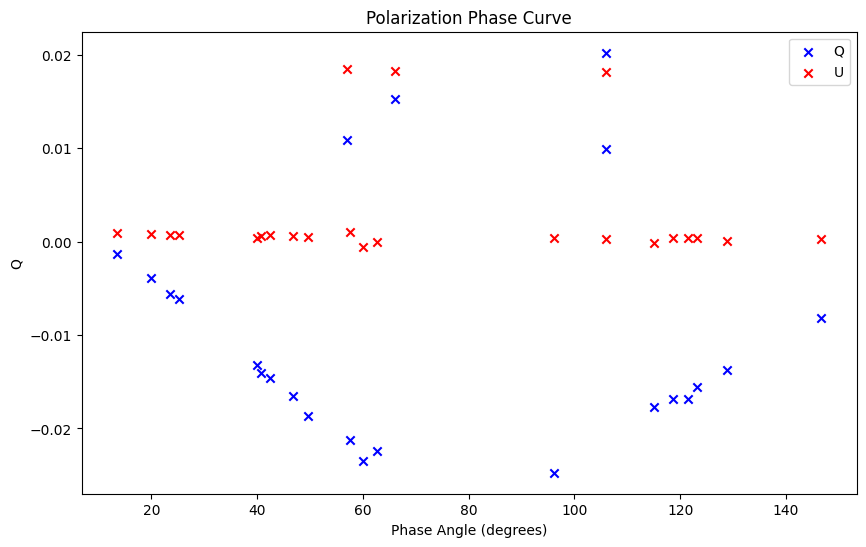

In [7]:
#For sanity we plot; looks pretty much exaclty the same whether or not we do the whole image os masked image
qmag = "Q"
umag = "U"

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, pre_rot_qs, color='b', marker='x', label=qmag)
plt.scatter(phase_angles, pre_rot_us, color='r', marker='x', label=umag)
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve')

plt.legend()
plt.show()

Stokes Parameters After Rotation

In [8]:
#There is a special case but we do not need it for the easy version

def rotate_scat_plane(q_o, u_o, rot_angle):
    #this will be the sun_image_azimuth
    thet_prime = np.deg2rad(-rot_angle)

    q_scat = q_o * np.cos(2 * thet_prime) + u_o * np.sin(2 * thet_prime)
    u_scat = -q_o * np.sin(2 * thet_prime) + u_o * np.cos(2 * thet_prime)

    #Special case where we rotate to U = 0
    #thet_special = 0.5 * np.arctan2(u_o, q_o)
    #q_spec = q_o * np.cos(2 * thet_special) + u_o * np.sin(2 * thet_special)
    
    return q_scat, u_scat

#From the brightness phase curves, for total intensity; but since we are only doing the mask

def reflectivity(if_image, center, radius, pixel_scale):
    R = 2575 #km
    #Total number of pixels
    #n_pixel = np.pi * R**2 / pixel_scale**2

    mask_if = np.zeros_like(if_image)
    cv2.circle(mask_if, center, radius, 1, thickness=-1)
    if_masked = if_image * mask_if
    
    total_if = np.sum(if_masked)

    return (total_if * pixel_scale**2) / (np.pi * R**2)

def rotate_scat_over_i(q_scat, u_scat, total_i):
    #q and u scat will be calculated with rotate scatter plane function
    #total i will be calculated with reflectivity
    #notable the normalization factors cancel out but don't want to rewrite everything

    q_over_i = q_scat / total_i
    u_over_i = u_scat / total_i

    return q_over_i, u_over_i

In [9]:
scat_qs = []
scat_us = []

scat_qis = []
scat_uis = []

for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        if_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        if_vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = if_vic.data_2d

        thet_image_path = pol_image_path.replace('_Pol.vic', '_Theta.vic')
        thet_vic = vicar.VicarImage(thet_image_path, strict=False)
        read_thet_image = thet_vic.data_2d

        opus_id = filename.split('_')[0]
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Only additions are simple_stokes_Q function for y axis change and adding pixel_scale
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
                pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]
                sun_image_azimuth = parameter_row['SUN_IMAGE_AZIMUTH'].values[0]
                
                prq = pre_rot_q(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)
                pru = pre_rot_u(read_pol_image, read_if_image, read_thet_image, center, eff_radius, pixel_scale)

                #sun_image_azimuth as the rotation angle, and converted to radians within the function

                scat_q, scat_u = rotate_scat_plane(prq, pru, sun_image_azimuth)
                calc_refl = reflectivity(read_if_image, center, eff_radius, pixel_scale)
                scat_qi, scat_ui = rotate_scat_over_i(scat_q, scat_u, calc_refl)

                #Creating array to plot
                scat_qs.append(scat_q)
                scat_us.append(scat_u)

                scat_qis.append(scat_qi)
                scat_uis.append(scat_ui)

                #For manual inspection
                print(f'{filename}: {scat_q}, {scat_u}, {scat_qi}, {scat_ui}')

N1486913_Pol.vic: -0.005611664330561098, 0.0007299438516096597, -0.05637001488330961, 0.007332396122685168
N1499415_Pol.vic: -0.02352250988593757, -0.0006380566894119493, -0.3476971777650653, -0.009431413196909067
N1515805_Pol.vic: -0.014105294642100683, 0.0005737312734696978, -0.1731868127637473, 0.0070443541348318055
N1525327_Pol.vic: -0.00814969341682696, 0.000252598864735278, -0.1358919753698291, 0.0042119570576948035
N1526619_Pol.vic: -0.024746347998922596, 0.0003010564803438337, -0.5631124272421586, 0.0068506530899338485
N1530756_Pol.vic: -0.016862791646660425, 0.00031880256235406894, -0.37977862834232384, 0.0071799736591553346
N1534852_Pol.vic: -0.015535347194409362, 0.0002850530986083565, -0.3676928071830011, 0.006746677284511393
N1536146_Pol.vic: -0.013738207092468839, 2.1487910652513236e-05, -0.30598791575711554, 0.00047859527449852055
N1547135_Pol.vic: -0.016822742877213803, 0.0002803812722333503, -0.428158870245125, 0.007136037781325497
N1549546_Pol.vic: -0.0176903511565563

Final Graphs

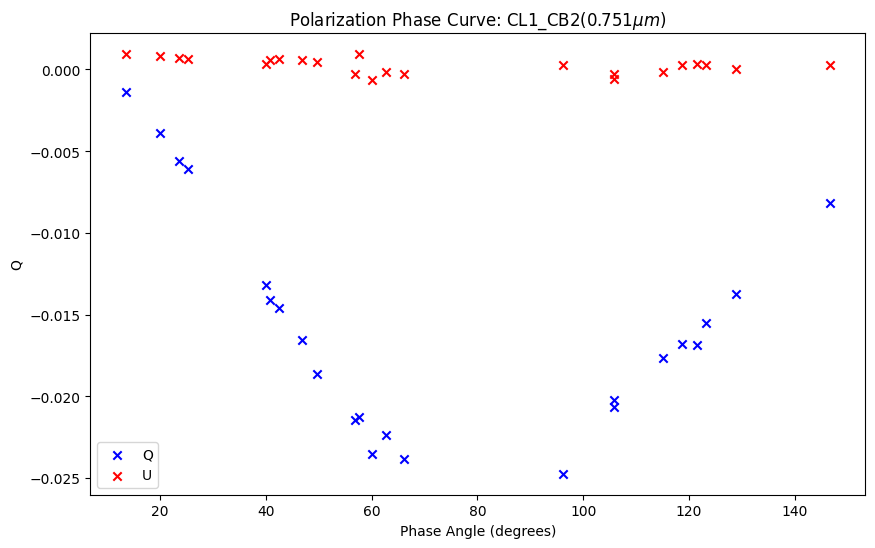

In [10]:
filtername = 'CL1_CB2'
wavelength = '(0.751'r'$\mu m$'')'

plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, scat_qs, color='b', marker='x', label=qmag)
plt.scatter(phase_angles, scat_us, color='r', marker='x', label=umag)
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q')
plt.title('Polarization Phase Curve: ' + filtername + wavelength)

plt.legend()
plt.show()

In [11]:
#Getting the phase angles for later use
for pa in phase_angles:
    print(f"{pa:.2f}")

23.48
59.99
40.75
146.70
96.19
121.49
123.18
128.86
118.59
115.10
62.67
46.82
39.99
25.27
19.95
13.47
42.39
57.52
56.90
66.11
49.66
105.90
105.90
